# 机器学习基础1-回归模型
参考：海口数据培训课程

## 目录

- 对Housing数据集进行探索性分析
- 实现一个简单的线性回归模型 - Ordinary least squares
    - 利用梯度下降求解回归系数
    - 利用scikit-learn计算回归
- 利用RANSAC拟合一个稳健的回归模型
- 线性回归模型性能评估
- 曲线拟合-多项式回归
- 对Housing数据集进行非线性建模

<br>
<br>

## 机器学习基础

目标：引入机器学习几个核心概念

In [2]:
from IPython.display import Image
%matplotlib inline

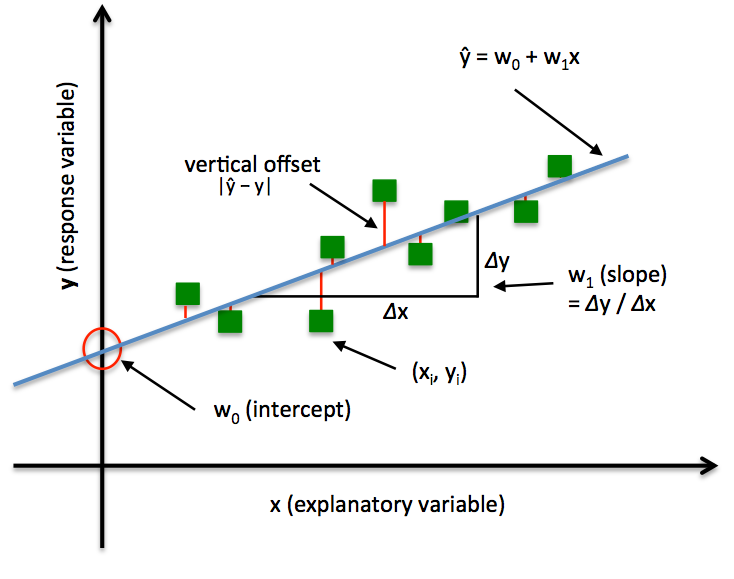

In [3]:
Image(filename='figures/10_01.png', width=500)

#### 回归分析的研究范围
- 线性回归：一元线性回归、多元线性回归和多个因变量与多个自变量的回归。
- 回归诊断：通过数据推断回归模型基本假设的合理性、基本假设不成立时对数据的修正、回归方程拟合效果的判断以及回归函数形式的选择。
- 回归变量的选择：根据什么标准选择自变量和逐步回归分析方法。
- 参数估计方法：偏最小二乘回归、主成分回归和岭回归。
- 非线性回归：一元非线性回归、分段回归和多元非线性回归。
- 定性变量的回归：因变量含有定性变量和自变量含有定性变量。

现实中常用的回归分析是线性回归、逻辑回归、多项式回归和岭回归。

# 对Housing数据集进行探索性分析

[[back to top](#目录)]

波士顿房价数据

Source: [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

Attributes:
    
```
1. CRIM      per capita crime rate by town 每个城镇人均犯罪率
2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft. 超过25000平方尺用地划为居住用地的百分比
3. INDUS     proportion of non-retail business acres per town 非零售商用地百分比
4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise) 是否被河道包围
5. NOX       nitric oxides concentration (parts per 10 million) 氮氧化物浓度
6. RM        average number of rooms per dwelling 住宅平均房间数目
7. AGE       proportion of owner-occupied units built prior to 1940 1940年前建成自用单位比例
8. DIS       weighted distances to five Boston employment centres 5个波士顿就业服务中心的加权距离
9. RAD       index of accessibility to radial highways 无障碍径向高速公路指数
10. TAX      full-value property-tax rate per $10,000 每万元物业税率
11. PTRATIO  pupil-teacher ratio by town 小学师生比例
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town 黑人比例指数
13. LSTAT    % lower status of the population 低层人口比例
14. MEDV     Median value of owner-occupied homes in $1000's 业主自住房屋中值 （要预测的变量）
```

In [1]:
# 读取数据
import pandas as pd
df = pd.read_csv('data/housing.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


第一步是进行**探索性数据分析 (Exploratory Data Analysis, EDA)**，理解变量的分布与变量之间的关系。

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


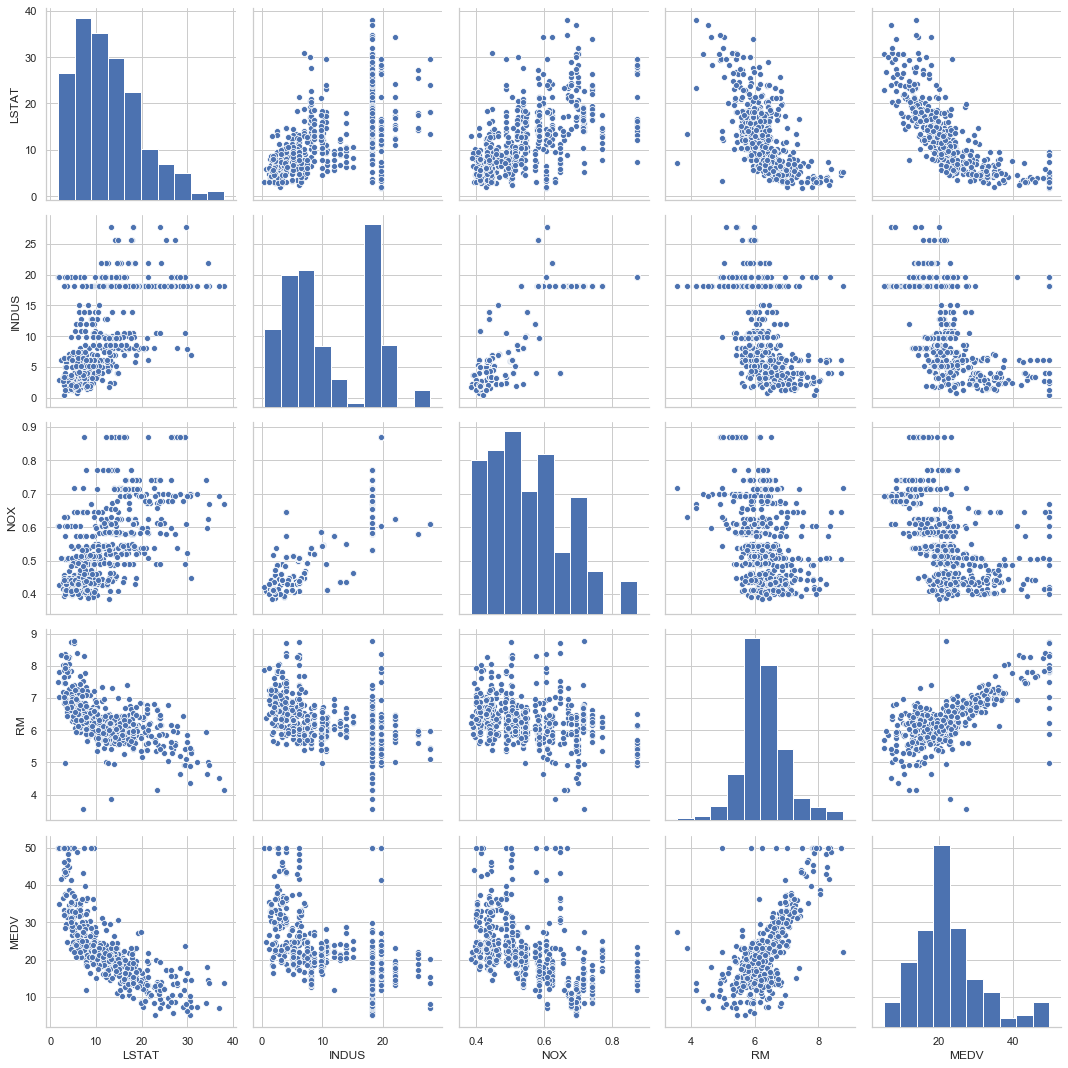

In [4]:
%matplotlib inline 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')  
# 此处使用seaborn，设定样式，还原可用 sns.reset_orig()

# MEDV 是目标变量，为了方便演示，只挑 4 个预测变量
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
# LSTAT:低层人口比例
# INDUS:非零售商用地百分比
# NOX:氮氧化物浓度
# RM:住宅平均房间数目
# MEDV:业主自住房屋中值   (Y)

# scatterplot matrix, 对角线上是变量分布的直方图，非对角线上是两个变量的散点图
sns.pairplot(df[cols], size=3)
plt.tight_layout()
#这是matplotlib的方法
#紧凑显示图片，居中显示

# 用下面这行代码可以存储图片到硬盘中
plt.savefig('./figures/scatter1.png', dpi=300)

从图中看出:
+ RM 和 MEDV 似乎是有线性关系的（估计）
+ MEDV 类似 normal distribution

In [5]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)  # 计算相关系数
sns.set(font_scale=1.5)

In [6]:
cm
# 相关关系矩阵

array([[ 1.        ,  0.60379972,  0.59087892, -0.61380827, -0.73766273],
       [ 0.60379972,  1.        ,  0.76365145, -0.39167585, -0.48372516],
       [ 0.59087892,  0.76365145,  1.        , -0.30218819, -0.42732077],
       [-0.61380827, -0.39167585, -0.30218819,  1.        ,  0.69535995],
       [-0.73766273, -0.48372516, -0.42732077,  0.69535995,  1.        ]])

人类生活的现实社会经常遇到分类与预测的问题，目标变量可能受多个因素影响，根据**相关系数**可以判断影响因子的重要性。正如一个病人得某种病是多种因素影响造成的。

### 相关系数的含义
- 皮尔逊相关系数所具有的性质如下：
    - |Corr(X,Y)|≤ 1
    - |Corr(X,Y)|=1的充要条件是存在常数a和b,使得Y = aX + b
    - 皮尔逊相关系数是对称的，即|Corr(X,Y)| = |Corr(Y,X)|
- 由此衍生出如下性质：皮尔逊相关系数刻画了变量X和Y之间线性相关程度，如果|Corr(X,Y)|的取值越大，则两者在线性相关的意义下相关程度越大。 |Corr(X,Y)| = 0表示两者不存在线性相关关系（可能存在其他非线性相关的关系）。
- 正线性相关意味着变量X增加的情况下，变量Y也随之增加；负线性相关意味着变量X减少的情况下，变量Y随之增加

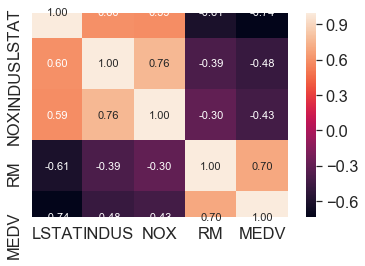

In [7]:
# correlation map
import numpy as np
cm = np.corrcoef(df[cols].values.T)  # 计算相关系数
sns.set(font_scale=1.5)

# 画相关系数矩阵的热点图
hm = sns.heatmap(cm, 
        annot=True, 
        square=True,
        fmt='.2f',
        annot_kws={'size': 11},
        yticklabels=cols,
        xticklabels=cols)
plt.tight_layout()
plt.savefig('./figures/corr_mat.png', dpi=300)

+ 对与 MEDV correlation 高的变量感兴趣,  LSTAT 最高(-0.74), 其次是 RM (0.7)
+ 但从之前的图看出 MEDV 与 LSTAT 呈非线性关系，而与 RM 更呈线性关系，所以下面选用 RM 来演示简单线性回归 

In [8]:
sns.reset_orig()

/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecate

## 机器学习的核心思想：

训练：通过大量数据找到合适的“函数”

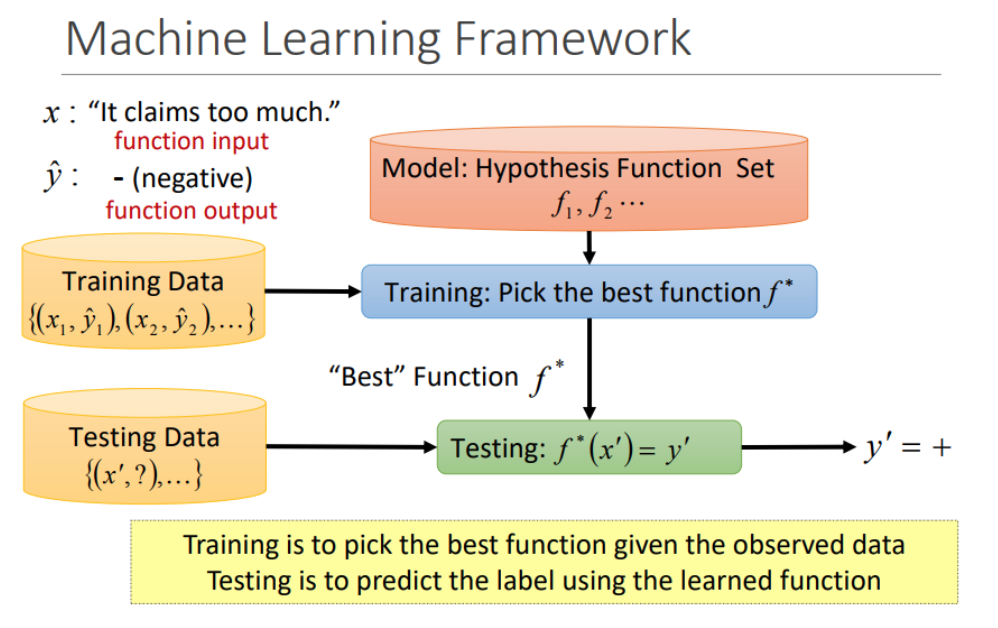

In [9]:
from IPython.display import Image
Image(filename='figures/mla.png', width=500)

<br>
<br>

# 实现简单的线性回归- Ordinary least squares

## 利用gradient descent求解回归系数

## 梯度下降法
梯度下降法是一个最优化算法，通常也称为最速下降法。最速下降法是求解无约束优化问题最简单和最古老的方法之一，虽然现在已经不具有实用性，但是许多有效算法都是以它为基础进行改进和修正而得到的。最速下降法是用负梯度方向为搜索方向的，最速下降法越接近目标值，步长越小，前进越慢。  

Wiki上的解释为如果目标函数$F(x)$在点$a$处可微且有定义，那么函数$F(x)$在点$a$沿着梯度相反的方向$-\nabla F(a)$下降最快。其中,$\nabla$为梯度算子，$\nabla = (\frac{\partial}{\partial x_1}, \frac{\partial}{\partial x_2}, \ldots, \frac{\partial}{\partial x_n})^T$  

#### 什么是梯度下降法？
- 梯度下降法，可作为一种求解最小二乘法的方式，它是最优化中比较古老的一种方法
- 梯度下降，设定起始点负梯度方向 (即数值减小的方向) 为搜索方向，寻找最小值。梯度下降法越接近目标值，步长越小，前进越慢.  

![gd](./figures/gd.png)

损失函数 $$ J(w) = \frac{1}{2} \sum^n_{i=1} (y^{(i)} - \hat y^{(i)})^2$$
梯度 $$ \frac {\partial J}{\partial w_j}=-\sum^n_{i=1} (y^{(i)}-\hat y^{(i)})x_j^{(i)}$$
更新规则 $$w:=w-\eta\frac{\partial J}{\partial w}$$

In [7]:
# 自行实现基于梯度下降的线性回归

class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta  # learning rate 学习速率
        self.n_iter = n_iter  # 迭代次数

    def fit(self, X, y):  # 训练函数
        # self.w_ = np.zeros(1, 1 + X.shape[1]) 
        self.coef_ = np.zeros(shape=(1, X.shape[1]))  # 代表被训练的系数，初始化为 0
        self.intercept_ = np.zeros(1)
        self.cost_ = []   # 用于保存损失的空list

        for i in range(self.n_iter):
            output = self.net_input(X)  # 计算预测的Y
            errors = y - output  
            self.coef_ += self.eta * np.dot(errors.T, X)
            # 根据更新规则更新系数，思考一下为什么不是减号？
            self.intercept_ += self.eta * errors.sum()  # 更新 bias，相当于x_0取常数1
            cost = (errors**2).sum() / 2.0     # 计算损失
            self.cost_.append(cost)  # 记录损失函数的值
        return self

    def net_input(self, X):   # 给定系数和X计算预测的Y
        return np.dot(X, self.coef_.T) + self.intercept_

    def predict(self, X):
        return self.net_input(X)

In [8]:
# RM 作为 explanatory variable
X = df[['RM']].values
y = df[['MEDV']].values

In [9]:
# standardize
# 为了方便，标准化的部分，我们直接调用sklearn来做
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

In [10]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std);  # 喂入数据进行训练

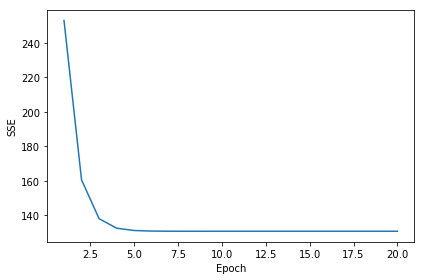

In [11]:
# cost function
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()

发现在 epoch 5之后 cost 基本就不能再减小了

In [12]:
# 定义一个绘图函数用于展示
def lin_regplot(X, y, model):
    # 画原始散点图
    plt.scatter(X, y, c='lightblue')
    # 画拟合的线
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return None

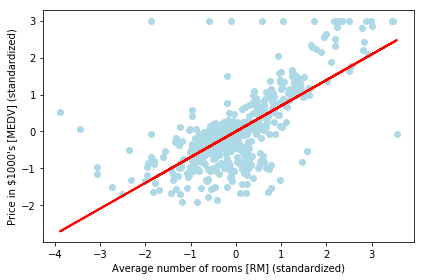

In [13]:
# 画出预测
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
#plt.show()

In [14]:
print('Slope: %.3f' % lr.coef_[0])
print('Intercept: %.3f' % lr.intercept_)
# 直线的斜率及截距

Slope: 0.695
Intercept: -0.000


In [15]:
# 预测 RM=5 时，房价为多少
num_rooms_std = sc_x.transform([[5.0]]) 
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


问题：
1. 这样准吗？?def acc
2. 那么多变量使用了一个靠谱吗？no multivar
3. 方便吗？no library scikit learn

<br>
<br>

## 最常用方法：利用scikit-learn做线性回归

[[back to top](#目录)]

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
slr = LinearRegression()
slr.fit(X_std, y_std)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 0.695
Intercept: -0.000


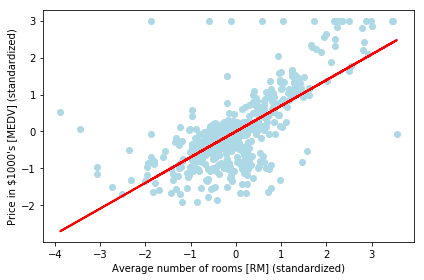

In [18]:
lin_regplot(X_std, y_std, slr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()

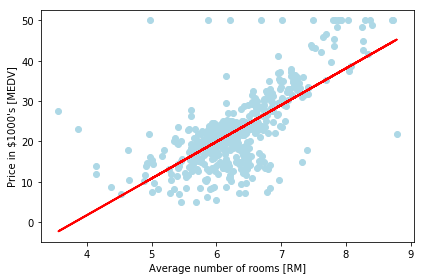

In [19]:
# 考虑如果不标准化，直接用原始数据进行回归
slr.fit(X, y)
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()

In [19]:
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


结果与使用 gradient descent 的结果接近，

问题：思考一下什么时候需要使用标准化？

<br>
<br>

# *使用RANSAC拟合稳健回归

[[back to top](#目录)]

线性回归对 outlier 比较敏感, 而对是否删除 outlier 是需要自己进行判断的. 

另一种方法就是 [RANdom SAmple Consensus (RANSAC)](http://scikit-learn.org/stable/modules/linear_model.html#ransac-random-sample-consensus)

大致算法如下:
1. 随机选择一组样本作为**内部数据**进行拟合模型
2. 利用拟合的模型测试其它数据，然后将符合用户指定的tolerance的数据添加到**内部数据**
3. 用所有**内部数据**再次拟合模型
4. 评估**内部数据**相对模型的错误
5. 如果模型性能达到用指定要求或者固定的迭代次数达到，则停止；不然返回第一步

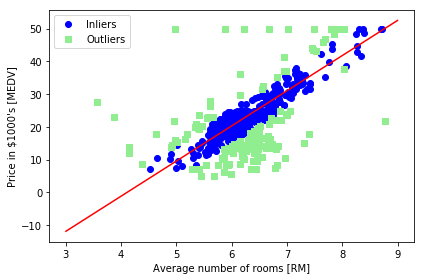

In [20]:
# 使用 sklearn 中已有函数
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, # max iteration
                         min_samples=50, # min number of randomly chosen samples
                         loss='absolute_loss', # absolute vertical distances to measure
                         residual_threshold=5.0, # allow sample as inlier within 5 distance units
                         random_state=0)
#  all data samples with absolute residuals smaller than the residual_threshold are considered as inliers.

ransac.fit(X, y)

# 分出 inlier 和 outlier
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')

plt.tight_layout()

In [21]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


RANSAC 减少了 outlier 的影响, 但对于未知数据的预测能力是否有影响未知.

对比 **RANSAC 回归**和**OLS 回归**（利用模型已知的模拟数据进行测试）：

Estimated coefficients (true, normal, RANSAC):
82.1903908407869 [ 54.17236387] [ 82.08533159]


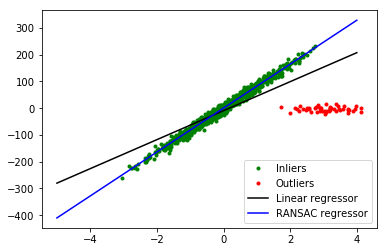

In [22]:
# 造一组数据进行模拟
from sklearn import datasets

n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# 添加 outlier 数据
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# 使用所有数据进行拟合
model = LinearRegression()
model.fit(X, y)

# 利用RANSAC 算法进行拟合
model_ransac = RANSACRegressor(LinearRegression())
model_ransac.fit(X, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# 预测数据
line_X = np.arange(-5, 5)
# 普通线性回归
line_y = model.predict(line_X[:, np.newaxis])
# ransac线性回归
line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])

# 对比预估的系数
print("Estimated coefficients (true, normal, RANSAC):")
print(coef, model.coef_, model_ransac.estimator_.coef_)

plt.plot(X[inlier_mask], y[inlier_mask], '.g', label='Inliers')
plt.plot(X[outlier_mask], y[outlier_mask], '.r', label='Outliers')
plt.plot(line_X, line_y, '-k', label='Linear regressor')
plt.plot(line_X, line_y_ransac, '-b', label='RANSAC regressor')
plt.legend(loc='lower right');

82.1903908407869 [ 54.17236387] [ 82.08533159]

RANSAC准确

<br>
<br>

# 评估线性回归模型的性能

即：怎么评估模型好坏？

It is crucial to test the model on data that it hasn't seen during training to obtain an unbiased estimate of its performance.

[[back to top](#目录)]

In [23]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

In [24]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
# 70% 用于 train, 30%用于 test

In [25]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

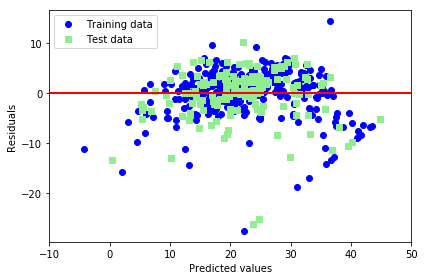

In [26]:
# residual plot, 残差图：经常被用来检查回归模型
plt.scatter(y_train_pred,  y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
# plt.savefig('./figures/slr_residuals.png', dpi=300)

如果预测都是正确的, 那么 residual 就是0. 这是理想情况

实际中, 我们希望 error 是随机分布的. 

从上图看, 有部分 error 是离红色线较远的, 可能是 outlier 引起较大的偏差

In [42]:
#应该随机分布
#1. 出现直线或者曲线，或者规律，考虑改变现有拟合方式

#2. 出现有的点，明显偏离，要检查，删掉此点

In [45]:
# 或者用上节的方法，在模型中增加特征（特征工程）
# 这里只涉及评估，后面会介绍修正的方法

In [27]:
# 另一种评估方法是 Mean Squred Error, MSE, 就是 SSE 的平均值
# R-squre 也是重要的 measurement, 它代表着有多少百分比的数据被模型解释. 越高代表模型拟合越好
# adjust R-squre

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

#泛化能力
#generalization

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


test上的r square 只有0.673，模型需要改进

$$ MSE = \frac 1 n \sum^n_{i=1} (y^{(i)} - \hat y^{(i)})$$
$$ R^2 = 1 - \frac{SSE}{SST} = 1 - \frac{MSE}{Var(y)}$$

In [ ]:
R-square确定系数
SSE: sum of squares due to error
SSR：sum of square of the regression()
SST：total sum of square

$$ SSE = \sum^n_{i=1} (y^{(i)} - \hat y^{(i)})^2$$
$$ SSR = \sum^n_{i=1} (\hat y^{(i)} - \bar y^{(i)})^2$$
$$ SST = \sum^n_{i=1} (y^{(i)} - \bar y^{(i)})^2$$

In [59]:
# 特征变换
# 换模型
# 去异常

<br>
<br>

# Polynomial regression多项式回归

[[back to top](#目录)]

##### 线性的拟合不好？改变特征？换换模型？

In [28]:
import numpy as np

In [29]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [30]:
# 添加二次项和截距项

from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

In [31]:
print(X.shape)
print(X_quad.shape)

(10, 1)
(10, 3)


In [32]:
X

array([[ 258.],
       [ 270.],
       [ 294.],
       [ 320.],
       [ 342.],
       [ 368.],
       [ 396.],
       [ 446.],
       [ 480.],
       [ 586.]])

In [33]:
X_quad

array([[  1.00000000e+00,   2.58000000e+02,   6.65640000e+04],
       [  1.00000000e+00,   2.70000000e+02,   7.29000000e+04],
       [  1.00000000e+00,   2.94000000e+02,   8.64360000e+04],
       [  1.00000000e+00,   3.20000000e+02,   1.02400000e+05],
       [  1.00000000e+00,   3.42000000e+02,   1.16964000e+05],
       [  1.00000000e+00,   3.68000000e+02,   1.35424000e+05],
       [  1.00000000e+00,   3.96000000e+02,   1.56816000e+05],
       [  1.00000000e+00,   4.46000000e+02,   1.98916000e+05],
       [  1.00000000e+00,   4.80000000e+02,   2.30400000e+05],
       [  1.00000000e+00,   5.86000000e+02,   3.43396000e+05]])

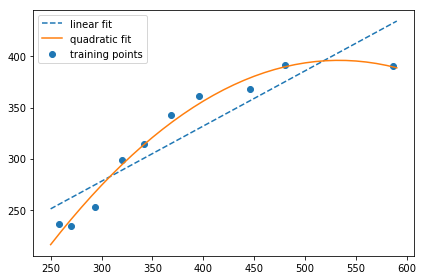

In [36]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250,600,10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()

图上可以发现 quadratic fit比 linear 拟合效果更好

不光看图，看看具体的评价指标：

In [37]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [38]:
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training  R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training  R^2 linear: 0.832, quadratic: 0.982


MSE 下降到61, R^2 上升到98%, 说明在这个数据集上 quadratic fit 效果更好

<br>
<br>

## 案例：为Housing数据集进行非线性建模

我们会将house prices 与 LSTAT 的 

quadratic 及 

cubic polynomials fit, 并与 

linear fit 对比

[back to top](## 目录)

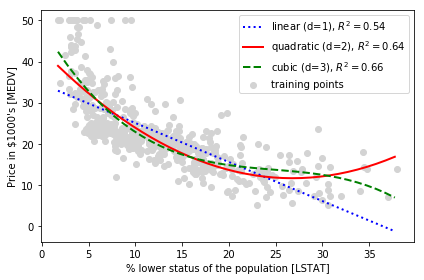

In [39]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)



# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

# 模型1
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))
# 模型2
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))
# 模型3
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('./figures/polyhouse_example.png', dpi=300)

polynomialfeature


In [76]:
# 变换特征

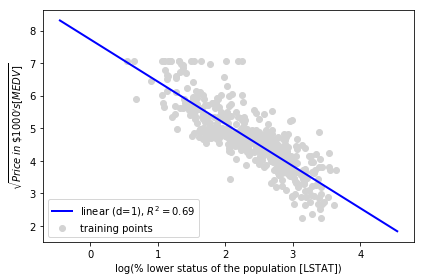

In [40]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

# 变换了特征
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
#plt.savefig('./figures/transform_example.png', dpi=300)
#plt.show()

经过 log 变换后，线性拟合效果已经不错, 比单纯 polynomial fit 更好

In [41]:
# 特征变换
# 换模型
# 去异常


[[ref](#评估线性回归模型的性能)]

In [88]:
# 回顾

#构造特征
a = df[['LSTAT']].values
a_log = np.log(a)
df['xxx'] = a_log

#构造X，y
cola = ['CRIM','LSTAT','xxx']
X = df[cola].values
y = df['MEDV'].values

#模型拟合
regr = LinearRegression()
regr = regr.fit(X, y)

#算分
linear_r2 = r2_score(y, regr.predict(X))